## **SEMICONDUCTOR Wafer defect classification**

## Mounting google drive and unzipping the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/semiconductor

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/semiconductor


In [ ]:
!unzip ExercisesTech.zip

Archive:  ExercisesTech.zip
  inflating: Exercises/Exercises.docx  
  inflating: Exercises/AdaptiveSampling.pdf  
  inflating: Exercises/waferImg26x26.pkl  


# Importing libraries 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Reading data as dataframe

In [ ]:
df_m = pd.read_pickle('Exercises/waferImg26x26.pkl')

# Understanding of data and preparing it for training

In [ ]:
df_0 = df_m[(df_m['labels'] == 'none')]
df_1 = df_m[(df_m['labels'] == 'Edge-Ring')]
df_2 = df_m[(df_m['labels'] == 'Edge-Loc')]
df_3 = df_m[(df_m['labels'] == 'Scratch')]
df_4 = df_m[(df_m['labels'] == 'Random')]
df_5 = df_m[(df_m['labels'] == 'Center')]
df_6 = df_m[(df_m['labels'] == 'Loc')]
df_7 = df_m[(df_m['labels'] == 'Near-full')]
df_8 = df_m[(df_m['labels'] == 'Donutg')]

df_0 = df_0[0:200]
df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8])
print(df.shape)

(1076, 2)


# Label decoding 

In [ ]:
images = df['images'].values
labels = df['labels'].apply(str).values
#labels = np.array(str(i[0]) for i in labels)

images = list(images) 
images = np.transpose(images,[0,2,3,1])
images = np.array(images)

#my_map = {'none': 0, 'Edge-Ring':1, 'Edge-Loc':2, 'Scratch':3, 'Random':4,'Center':5, 'Loc':6, 'Near-full':7, 'Donut':8}
my_map = {"['none']": 0, "['Edge-Ring']":1, "['Edge-Loc']":2, "['Scratch']":3, "['Random']":4,"['Center']":5, "['Loc']":6, "['Near-full']":7, "['Donut']":8}

label = np.vectorize(my_map.get)(labels) 

print(label.shape) 
print(images.shape)

(1076,)
(1076, 26, 26, 3)


# Preparing the dataset and visualizaion

(1076, 26, 26, 3)
(1076,)


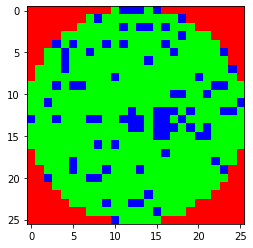

tf.Tensor(6, shape=(), dtype=int64)
Number of train batches: 13451
Number of val batches: 3362


In [ ]:
print(images.shape)
print(label.shape)
BATCH_SIZE = 32

dataset=tf.data.Dataset.from_tensor_slices((images,label))


dataset = dataset.repeat(500)
dataset = dataset.shuffle(5000)
dataset = dataset.batch(batch_size=BATCH_SIZE)

for img, lbl in dataset.take(1):
  plt.imshow(img[0])
  plt.show()
  print(lbl[0])


train_batches = tf.data.experimental.cardinality(dataset)
train_ds = dataset.skip(train_batches // 5)
val_ds = dataset.take(train_batches // 5)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of val batches: %d' % tf.data.experimental.cardinality(val_ds))


#Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(26, 26,3)),
    layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(26, 26,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    #layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# Model building 

In [ ]:
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
image_shape = (None, 26, 26,3)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.build(image_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 26, 26, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 26, 26, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                  

# Model Training 

In [ ]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


13451/13451 [==============================] - 126s 9ms/step - loss: 0.6999 - accuracy: 0.7269 - val_loss: 0.4889 - val_accuracy: 0.8168
Epoch 2/20
13451/13451 [==============================] - 121s 9ms/step - loss: 0.3932 - accuracy: 0.8464 - val_loss: 0.3203 - val_accuracy: 0.8679
Epoch 3/20
13451/13451 [==============================] - 123s 9ms/step - loss: 0.2937 - accuracy: 0.8858 - val_loss: 0.2218 - val_accuracy: 0.9098
Epoch 4/20
13451/13451 [==============================] - 122s 9ms/step - loss: 0.2410 - accuracy: 0.9056 - val_loss: 0.1362 - val_accuracy: 0.9499
Epoch 5/20
13451/13451 [==============================] - 122s 9ms/step - loss: 0.2023 - accuracy: 0.9212 - val_loss: 0.1336 - val_accuracy: 0.9432
Epoch 6/20
13451/13451 [==============================] - 122s 9ms/step - loss: 0.1749 - accuracy: 0.9320 - val_loss: 0.1082 - val_accuracy: 0.9591
Epoch 7/20
13451/13451 [==============================] - 123s 9ms/step - loss: 0.1555 - accuracy: 0.9401 - val_loss: 0.132

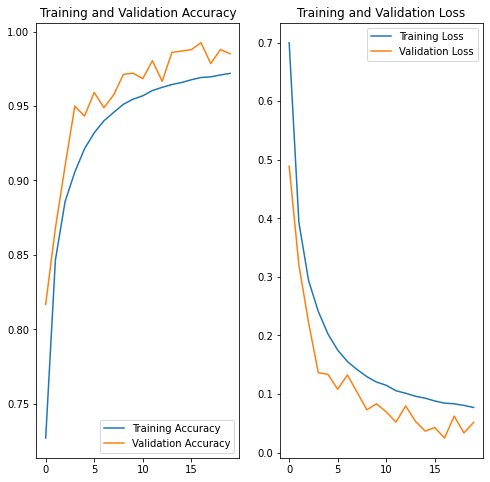

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Inference 

In [ ]:
import os
model.save(os.path.join('/content/gdrive/My Drive/semiconductor/','semi_model_v2.h5'))
#model = tf.keras.models.load_model(os.path.join('/content/gdrive/My Drive/semiconductor','semi_model_v2.h5'))

In [ ]:
classes = ['none','Edge-Ring','Edge-Loc','Scratch','Random','Center','Loc','Near-full','Donut']

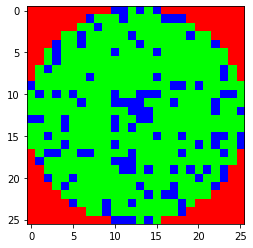

Target: Center
prediction:  Center ; probability:  99.99985694885254


In [ ]:
i=24
#val_ds=val_ds.shuffle(32)
for img, lbl in val_ds.take(1):
  plt.imshow(img[i])
  plt.show()
  print('Target:',classes[lbl[i]])
  predictions = model.predict(img)
  elem = np.argmax(predictions[i])
  score = np.max(predictions[i])
  print("prediction: ",classes[elem], "; probability: ",score*100)

In [ ]:
import itertools    
def plot_confusion_matrix(cm, classes):
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    #threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

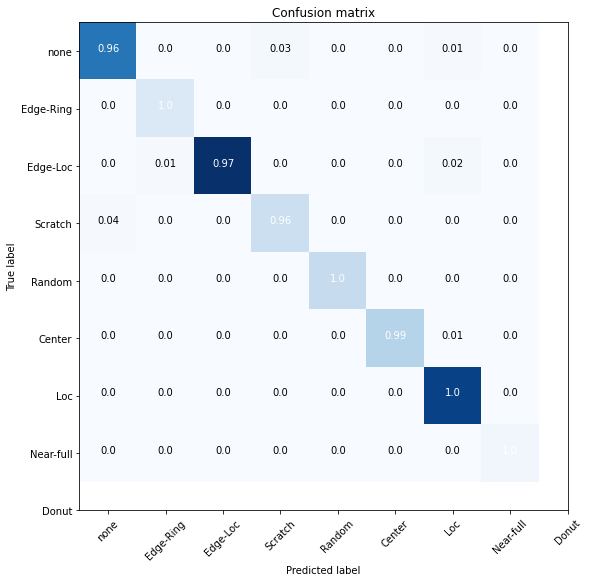

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix


label_test = np.ndarray([])
y_pred_series = np.ndarray([])
i=0

for element in val_ds.take(50):
  y_pred = model.predict(element[0])
  y_pred = y_pred.argmax(axis=-1)
  y_pred_series = np.append(y_pred_series,y_pred)
  lbl=element[1].numpy()
  label_test=np.append(label_test,lbl)
  i = i+1

cm = confusion_matrix(label_test,y_pred_series)

plot_confusion_matrix(cm, classes)